In [1]:
%load_ext autoreload
%autoreload 2

import torch as t
import requests
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [2]:
device = t.device("cuda:2" if t.cuda.is_available() else "cpu")

In [3]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

2024-03-01 12:12:54.216896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:12:54.216924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:12:54.217804: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 12:12:54.222501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 12:12:54.728891: W tensorflow/compiler/tf2

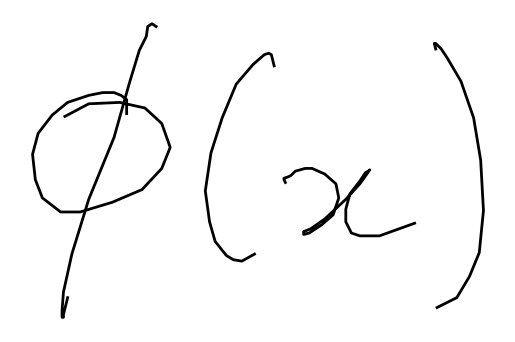

In [ ]:
raw_image = Image.open("../img_data/inkML_data_CROHME_training_2011_formulaire001-equation001.inkml_0.png").convert('RGB')
raw_image

### Before Finetuning:

In [8]:
pixel_values = processor(images = raw_image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values)
print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

p ( see ).


### Pretraining step on large dataset (rendered LaTeX)

In [6]:
# Load LST files
import pandas as pd
import numpy as np
import re
train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1").read()
# Use regex to split formula by \\label{...}
import re
formulas = re.split(r"\\label{.*?}", formulas)
formulas = [f.strip() for f in formulas] # Removing whitespace

In [12]:
import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

# processed_formulas = []
# for formula in formulas:
#     formula_processed = renderedLaTeXLabelstr2Formula(formula)
#     if len(formula_processed.replace('\n','')) != 0:
#         processed_formulas.append(formula)

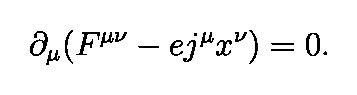

<IPython.core.display.Math object>

P_{(2)}^-=\int \beta d\beta d^9p d^8\lambda \Phi(-p,-\lambda)\left(-\frac{p^Ip^I}{2\beta}\right) \Phi(p,\lambda)\,.
V_{ns}({\tilde x})= \left(\frac{{\tilde m}N^2}{16\pi}\right)N g^{2ns-1}{\tilde x}^2 \left\{{\tilde x}^2 -\frac{2{\tilde b}}{3}{\tilde x}+\frac{{\tilde b}^2}{3} -(-1)^{ns}{\tilde c}\right\} \,.
g_{ij}(x)={1\over a^2}\,\delta_{ij},~~\phi^a(x)=\phi^a,\quad (a,\phi^a\!:~{\rm const.})


In [24]:
random_idx = 9 #np.random.choice(train_filenames_df.index)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[random_idx, 1] + ".png").convert('RGBA')

display(crop_to_formula(formula_image_example))
from IPython.display import display, Math, Latex
display_formula(renderedLaTeXLabelstr2Formula(formulas[random_idx]))
print(renderedLaTeXLabelstr2Formula(formulas[random_idx]))

In [8]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class renderedLaTeXDataset(Dataset):
    def __init__(self, image_folder, lst_file, formulas_file, processor, device = device):
        self.image_folder = image_folder
        self.lst_file = lst_file
        self.formulas_file = formulas_file
        self.train_filenames_df = pd.read_csv(self.lst_file, sep=" ", index_col = 0, header = None)
        self.formulas = open(self.formulas_file, encoding = "ISO-8859-1").readlines()
        self.processor = processor
        self.device = device
        
    def __len__(self):
        return len(self.train_filenames_df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.train_filenames_df.iloc[idx, 0] + ".png")
        image = Image.open(img_name).convert('RGBA')
        image = crop_to_formula(image)
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        formula_idx = self.train_filenames_df.iloc[idx].index[0]
        caption = self.formulas[formula_idx].split("\label")[0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this
            ).to(self.device).squeeze()
        
        return inputs, caption

In [9]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 2
LEARNING_RATE = 5e-5
BATCH_SIZE = 4 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = renderedLaTeXDataset(image_folder = "../formula_images/", 
                                lst_file = "../rendered_LaTeX/im2latex_train.lst", 
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst", 
                                processor = processor)
val_ds = renderedLaTeXDataset(image_folder = "../formula_images/",
                                lst_file = "../rendered_LaTeX/im2latex_validate.lst",
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst",
                                processor = processor)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = SHUFFLE_DATASET)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()

history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.95
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/2:   0%|          | 80/20971 [00:37<2:41:05,  2.16it/s, loss=1.34]


ValueError: zero-size array to reduction operation minimum which has no identity

### Finetuning:

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "../img_data", 
                 csv_file = "labels.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train": img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])
        else: img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx, 1])

        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        if self.partition == "train": caption = self.labels.iloc[idx, 0]
        else: caption = self.labels_val.iloc[idx, 0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this, longest length in current dataset is 156
            ).to(self.device).squeeze()

        return inputs, caption

In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
BATCH_SIZE = 8 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
assert (train_ds.labels_val.values == val_ds.labels_val.values).all()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()

history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/3:   0%|          | 0/1110 [00:00<?, ?it/s]

Epoch 1/3:   0%|          | 0/1110 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 2 has a total capacity of 23.69 GiB of which 71.75 MiB is free. Including non-PyTorch memory, this process has 23.61 GiB memory in use. Of the allocated memory 22.25 GiB is allocated by PyTorch, and 1.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:
model.save_pretrained("trocr_model")
processor.save_pretrained("trocr_processor")

[]

In [22]:
# Load model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("trocr_model").to(device)
processor = TrOCRProcessor.from_pretrained("trocr_processor")

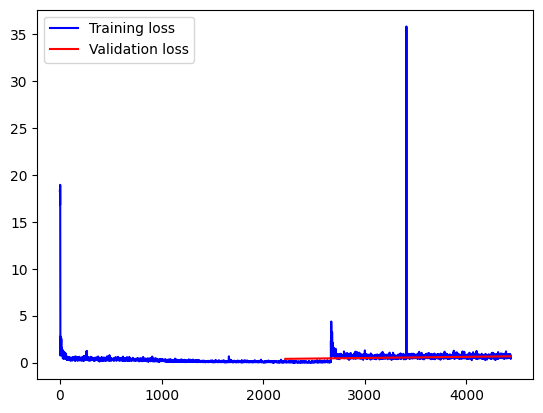

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data = history, color = "blue", label = "Training loss")
sns.lineplot(x = val_timesteps, y = val_history, color = "red", label = "Validation loss")
plt.legend()
plt.show()

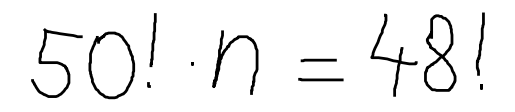

Prediction:



<IPython.core.display.Math object>

Gt:
$5 0 ! \cdot n = 4 8 !$


<IPython.core.display.Math object>

In [25]:
import random
# Randomly select a validation image and caption
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))
print("Gt:")
print(caption)
display(Math(caption))

### Validation on REAL handwritten digits

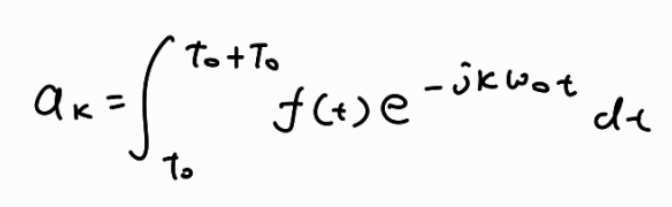

Prediction:
$a_k = \int^{\pi + \beta f(x)e^{-j^{-j}}$


<IPython.core.display.Math object>

In [51]:
import random
image = Image.open("../demo/demo.png").convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))